# Fáza 3 - strojové učenie

**Michaela Gubovská, Jakub Hajdu**

V tejto fáze ja ňevjem uš

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import category_encoders as ce
from datetime import datetime
from sklearn.impute import SimpleImputer, KNNImputer
from copy import deepcopy
from scipy import mean
from sklearn import tree, metrics

xtrain = pd.read_csv("data/X_train.csv", sep=',')
xtest = pd.read_csv("data/X_test.csv", sep=',')
ytrain = pd.read_csv("data/y_train.csv", sep=',')
ytest = pd.read_csv("data/y_test.csv", sep=',')

Načítali sme si trénovacie a testovacie dáta.

In [2]:
xtrain.head()

,hematokrit,hemoglobin,er-cv,erytrocyty,hbver
0,0.489452,0.781517,0.365514,0.493230,0.458152
1,0.632758,0.324983,0.464994,0.562196,0.680407
2,0.509218,0.604928,0.540910,0.470804,0.371400
3,0.613710,0.483566,0.588659,0.497569,0.347080
4,0.456906,0.723530,0.321346,0.477563,0.261482


In [3]:
ytrain.head()

,indicator
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0


Vytvoríme si zlúčený trénovací dataframe pre jednoduhšiu prácu pri OneR klasifikácii.

In [4]:
train_join = xtrain.join(ytrain)
train_join

,hematokrit,hemoglobin,er-cv,erytrocyty,hbver,indicator
0,0.489452,0.781517,0.365514,0.493230,0.458152,1.0
1,0.632758,0.324983,0.464994,0.562196,0.680407,0.0
2,0.509218,0.604928,0.540910,0.470804,0.371400,0.0
3,0.613710,0.483566,0.588659,0.497569,0.347080,0.0
4,0.456906,0.723530,0.321346,0.477563,0.261482,0.0
...,...,...,...,...,...,...
7433,0.599123,0.666367,0.750780,0.116027,0.515945,1.0
7434,0.795075,0.003092,0.494317,0.229950,0.512240,0.0
7435,0.481418,0.620453,0.577534,0.300379,0.594770,1.0
7436,0.344020,0.363165,0.536503,0.393597,0.535648,1.0


Už vo fáze EDA sme videli výraznejšiu závislosť indikátora a hemoglobínu, taktiež indikátora a hematokritu. Tieto dva atribúty po predspracovaní rovnako skončili medzi najdôležitejšími ohľadom vplyvu na indikátor. Úplne manuálne by sa dali pravidlá pre OneR algoritmus stanoviť napríklad tak, že sa pozrieme na rozdielne priemery atribútu skupiny s indikátorom 0 v porovnaní s indikátorom 1. 

[Text(0.5, 0, 'indicator'), Text(0, 0.5, 'hemoglobin')]

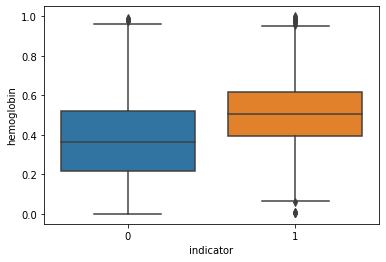

In [5]:
xtrain0 = train_join[train_join['indicator']==0]
xtrain1 = train_join[train_join['indicator']==1]
sns.boxplot(data=[xtrain0['hemoglobin'], xtrain1['hemoglobin']]).set(xlabel='indicator', ylabel='hemoglobin')

Napríklad pri hemoglobíne by sme mohli povedať, že by rozhodla hodnota v strede medzi priemermi skupín s indikátorom 0 a 1.
Menšie hodnoty ako táto hranica by klasifikovali indikátor 0, naopak vyššie by znamenali indikátor 1. Táto hodnota je:

In [6]:
manual_value = np.mean([xtrain0['hemoglobin'].mean(), xtrain1['hemoglobin'].mean()])
manual_value

0.44151760432413656

Spočítame si úspešnosť na trénovacom sete.

In [7]:
correct = 0
for i in range(len(train_join)):
    value = train_join.iloc[i]['hemoglobin']
    if train_join.iloc[i]['hemoglobin'] < manual_value:
        if ytrain.iloc[i]['indicator']==0:
            correct += 1
    else:
        if ytrain.iloc[i]['indicator']==1:
            correct += 1
correct/len(train_join)

0.6411669803710675

Vidíme, že úspešnosť takto zvoleného pravidla sa blíži k dvom tretinám. Dá sa však zlepšiť.

## 1. Manuálne vytvorenie a vyhodnotenie rozhodovacích pravidiel pre klasifikáciu

Definujeme si funkciu, ktorá vytvorí pravidlá pre OneR algoritmus.

- na vstupe očakáva dataframe s atribútmi a indikátorom, stĺpce, pre ktoré chceme vytvárať pravidlá a počet skupín
- podľa buckets sa dataframe rozdelí na skupiny, ktoré slúžia na diskretizáciu hodnôt
- body na hranici týchto buckets sú potenciálne body binárneho delenia na indikátor 0 a 1
- každý z týchto bodov sa skúma na úspešnosť klasifikácie záznamov menších a väčších ako daná hodnota
- najlepší bod rozdelenia so svojou úspešnosťou je vybratý ako pravidlo
- pravidlá sa ukladajú do svojho dataframe a nakoniec sú zoradené od najúspešnejšieho

In [8]:
def one_r_make_rules(data, cols, buckets):
    
    rules = pd.DataFrame(columns=['attribute', 'value', 'smaller', 'importance'])
    
    for attribute in cols:
        scores = pd.DataFrame(columns=['value', 'smaller', 'success'])
        data_sort = data[[attribute, 'indicator']].sort_values(by=attribute)
        
        for i, point in enumerate(np.arange(len(data_sort)//buckets, len(data_sort), len(data_sort)//buckets)):
            data_left = data_sort[:point]
            data_right = data_sort[point:]
            success = (len(data_left[data_left['indicator']==0]) + len(data_right[data_right['indicator']==1])) / len(data_sort)
            if success < 0.5:
                scores = scores.append({'value':data_sort.iloc[point][attribute], 'smaller':1, 'success':1-success}, ignore_index=True)
            else:
                scores = scores.append({'value':data_sort.iloc[point][attribute], 'smaller':0, 'success':success}, ignore_index=True)
        #print(scores)
        best = scores.sort_values(by='success', ascending=False).reset_index().loc[0]
        rules = rules.append({'attribute':attribute, 'value':best['value'], 'smaller':best['smaller'], 'importance':best['success']}, ignore_index=True)
    
    rules = rules.sort_values(by='importance', ascending=False).reset_index()
    return rules

Funkcia na čitateľný výpis vytvorených pravidiel

- best = True vypíše len najlepšie pravidlo, False vypíše všetky

In [9]:
def one_r_print_rules(rules, best):
    if best:
        print('If', rules.iloc[0]['attribute'], 'is smaller than', rules.iloc[0]['value'], ': indicator =', int(rules.iloc[0]['smaller']), 'importance:', rules.iloc[0]['importance'], '\n')
    else:
        for i in range(len(rules)):
            print('If', rules.iloc[i]['attribute'], 'is smaller than', rules.iloc[i]['value'], ': indicator =', int(rules.iloc[i]['smaller']), 'importance:', rules.iloc[i]['importance'], '\n')

Ďalej si definujeme funkciu, ktorá vykoná samotnú klasifikáciu, vracia dataframe s klasifikovanými hodnotami indikátora

In [10]:
def one_r_classify(data, rule):
    lo = rule['smaller']
    hi = 1.0 if lo == 0 else 0.0
    
    result = pd.DataFrame(columns=['indicator'])
    
    for i in range(len(data)):
        value = data.iloc[i][rule['attribute']]
        if value < rule['value']:
            result = result.append({'indicator':lo}, ignore_index=True)
        else:
            result = result.append({'indicator':hi}, ignore_index=True)
    return result

In [11]:
# toto pojde asi potom prec
def count_positives_negatives(classified, train):
    tp = tn = fp = fn = 0
    for i in range(len(train)):
        a = train.iloc[i]['indicator']
        b = classified.iloc[i]['indicator']
        if a == b:
            if a == 0:
                tn += 1
            else:
                tp += 1
            
        else:
            if a == 0:
                fp += 1
            else:
                fn += 1
            
    return tp, tn, fp, fn

In [12]:
rules = one_r_make_rules(train_join, xtrain.columns, 50)
one_r_print_rules(rules, False)

If hemoglobin is smaller than 0.2838841865790894 : indicator = 0 importance: 0.7225060500134445 

If hematokrit is smaller than 0.5895401015348607 : indicator = 1 importance: 0.6628125840279645 

If erytrocyty is smaller than 0.8498849070929964 : indicator = 1 importance: 0.6472169938155419 

If hbver is smaller than 0.8278276577878817 : indicator = 1 importance: 0.64425920946491 

If er-cv is smaller than 0.9406695269801008 : indicator = 1 importance: 0.6437214304920678 



Po skúšaní rôzneho počtu bucketov sme prišli na to, že 50 poskytuje dostatočne detailné "rozlíšenie" hraničnej hodnoty, možno by stačilo aj 10 alebo 15. Naopak 500 bucketov nemalo prakticky takmer žiadny efekt na úspešnosť pravidla (nárast o 0,1%).

Môžeme sa pozrieť na úspešnosť takéhoto klasifikátora na testovacom sete. Vidíme, že má veľmi podobnú úspešnosť:

In [39]:
ytest_classified = one_r_classify(xtest, rules.loc[0])
tp, tn, fp, fn = count_positives_negatives(ytest_classified, ytest)

In [16]:
print(f'No. of true positives: {tp}\nNo. of true negatives: {tn}\nNo. of false positives: {fp}\nNo. of false negatives: {fn}')

No. of true positives: 1486
No. of true negatives: 279
No. of false positives: 608
No. of false negatives: 107


**Vyhodnotenie pomocou metriky accuracy** (počet true positive + počet true negative / počet všetkých)

In [40]:
from sklearn import metrics
print('Accuracy :', metrics.accuracy_score(ytest, ytest_classified) * 100, '%')

Accuracy : 71.16935483870968 %


**Vyhodnotenie pomocou metriky precision** (počet true positive / (počet true positives + počet false positives))

In [41]:
print('Precision :', metrics.precision_score(ytest, ytest_classified) * 100, '%')

Precision : 70.96466093600765 %


**Vyhodnotenie pomocou metriky recall** (počet true positives / (počet true positives + počet false negatives))

In [42]:
print('Recall :', metrics.recall_score(ytest, ytest_classified) * 100, '%')

Recall : 93.28311362209666 %


Na základe vyhodnotení môžeme povedať, že nami vytvorený klasifikátor dosahuje dobrú úspešnosť.

## 2. Natrénovanie a vyhodnotenie klasifikátora strojového učenia

V tejto časti sme zvolili požiť Decision Tree klasifikátor z knižnice sklearn.

Najskôr si natrénujeme klasifikátor na naše trénovacie dáta.

[Text(77.7959078261234, 212.91, 'X[1] <= 0.287\ngini = 0.458\nsamples = 7438\nvalue = [2636, 4802]'),
 Text(18.171426954220976, 203.85, 'X[0] <= 0.439\ngini = 0.409\nsamples = 1370\nvalue = [978, 392]'),
 Text(6.266278367723834, 194.79, 'X[3] <= 0.391\ngini = 0.168\nsamples = 194\nvalue = [18, 176]'),
 Text(4.54216003125333, 185.73, 'X[0] <= 0.417\ngini = 0.122\nsamples = 184\nvalue = [12, 172]'),
 Text(2.2354086017686545, 176.67, 'X[4] <= 0.309\ngini = 0.071\nsamples = 162\nvalue = [6, 156]'),
 Text(1.141485243456334, 167.60999999999999, 'X[1] <= 0.242\ngini = 0.48\nsamples = 5\nvalue = [2, 3]'),
 Text(0.7609901623042228, 158.55, 'X[0] <= 0.259\ngini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(0.3804950811521114, 149.49, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(1.141485243456334, 149.49, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(1.5219803246084456, 158.55, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(3.3293319600809745, 167.60999999999999, 'X[2] <= 0.035\ngini 

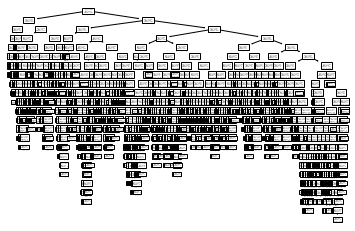

In [20]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(xtrain, ytrain)

tree.plot_tree(clf) 

Natrénovaný klasifikátor spraví predikciu na našu testovaciu množinu dát a následne sa pozrieme akú úspešnosť pri klasifikácii dát dosiahol.

In [28]:
ypred = clf.predict(xtest)

In [31]:
print("Accuracy :", metrics.accuracy_score(ytest, ypred) * 100, '%')

Accuracy : 78.75 %


In [32]:
print("Precision :", metrics.precision_score(ytest, ypred) * 100, '%')

Precision : 83.02354399008675 %


In [33]:
print("Recall :", metrics.recall_score(ytest, ypred) * 100, '%')

Recall : 84.11801632140616 %


Podľa výsledkov vidíme, že takýto klasifikátor bez použitia hyperparamtrov dosiahol dobrú úspešnosť.

Oproti nami vytvorenému One-R klasifikátoru dosiahol tento rozhodovací strom vyššiu accuracy aj precision, avšak recall dosiahol menší.

## 3. Optimalizácia - hyperparameter tuning

Pre dosianutie lepších výsledkov, teda vyššej presnosti klasifikácie dát sa v tejto časti pozrieme na niekoľko možných hyperparametrov pre nami zvolený algoritmus rozhodovacieho stromu.

**max_depth**

[Text(122.52602848101266, 205.35999999999999, 'X[1] <= 0.287\ngini = 0.458\nsamples = 7438\nvalue = [2636, 4802]'),
 Text(46.88259493670886, 181.2, 'X[0] <= 0.439\ngini = 0.409\nsamples = 1370\nvalue = [978, 392]'),
 Text(21.10158227848101, 157.04, 'X[3] <= 0.391\ngini = 0.168\nsamples = 194\nvalue = [18, 176]'),
 Text(15.362658227848101, 132.88, 'X[0] <= 0.417\ngini = 0.122\nsamples = 184\nvalue = [12, 172]'),
 Text(8.122784810126582, 108.72, 'X[4] <= 0.309\ngini = 0.071\nsamples = 162\nvalue = [6, 156]'),
 Text(4.237974683544303, 84.56, 'X[1] <= 0.242\ngini = 0.48\nsamples = 5\nvalue = [2, 3]'),
 Text(2.8253164556962025, 60.400000000000006, 'X[0] <= 0.259\ngini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(1.4126582278481012, 36.24000000000001, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(4.237974683544303, 36.24000000000001, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(5.650632911392405, 60.400000000000006, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(12.0075949367088

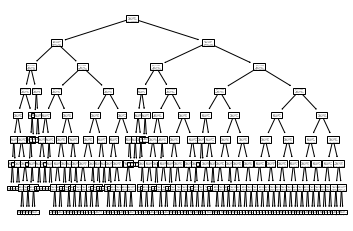

In [64]:
clf1 = tree.DecisionTreeClassifier(max_depth=8)
clf1 = clf1.fit(xtrain, ytrain)

tree.plot_tree(clf1)

In [65]:
ypred1 = clf1.predict(xtest)

In [66]:
print("Accuracy :", metrics.accuracy_score(ytest, ypred1) * 100, '%')

Accuracy : 83.06451612903226 %


**gini**

[Text(79.03034833828701, 212.91, 'X[1] <= 0.287\ngini = 0.458\nsamples = 7438\nvalue = [2636, 4802]'),
 Text(19.592795148175885, 203.85, 'X[0] <= 0.439\ngini = 0.409\nsamples = 1370\nvalue = [978, 392]'),
 Text(7.533925323633251, 194.79, 'X[3] <= 0.391\ngini = 0.168\nsamples = 194\nvalue = [18, 176]'),
 Text(5.1340537070717875, 185.73, 'X[0] <= 0.417\ngini = 0.122\nsamples = 184\nvalue = [12, 172]'),
 Text(2.244656039370921, 176.67, 'X[4] <= 0.309\ngini = 0.071\nsamples = 162\nvalue = [6, 156]'),
 Text(0.7641382261688242, 167.60999999999999, 'X[0] <= 0.286\ngini = 0.48\nsamples = 5\nvalue = [2, 3]'),
 Text(0.3820691130844121, 158.55, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(1.1462073392532364, 158.55, 'X[1] <= 0.242\ngini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(0.7641382261688242, 149.49, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(1.5282764523376484, 149.49, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(3.725173852573018, 167.60999999999999, 'X[2] <= 0.035\ngi

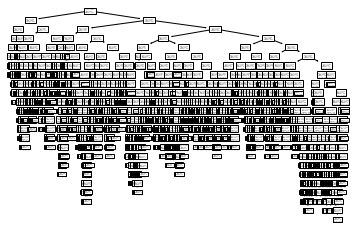

In [67]:
clf2 = tree.DecisionTreeClassifier(criterion='gini')
clf2 = clf2.fit(xtrain, ytrain)

tree.plot_tree(clf2)

In [68]:
ypred2 = clf2.predict(xtest)

In [69]:
print("Accuracy :", metrics.accuracy_score(ytest, ypred2) * 100, '%')

Accuracy : 78.91129032258064 %


**max_depth + gini**

[Text(122.9015428870293, 205.35999999999999, 'X[1] <= 0.287\ngini = 0.458\nsamples = 7438\nvalue = [2636, 4802]'),
 Text(47.19069037656904, 181.2, 'X[0] <= 0.439\ngini = 0.409\nsamples = 1370\nvalue = [978, 392]'),
 Text(22.325836820083683, 157.04, 'X[3] <= 0.391\ngini = 0.168\nsamples = 194\nvalue = [18, 176]'),
 Text(15.234100418410042, 132.88, 'X[0] <= 0.417\ngini = 0.122\nsamples = 184\nvalue = [12, 172]'),
 Text(8.054811715481172, 108.72, 'X[4] <= 0.309\ngini = 0.071\nsamples = 162\nvalue = [6, 156]'),
 Text(4.202510460251046, 84.56, 'X[1] <= 0.242\ngini = 0.48\nsamples = 5\nvalue = [2, 3]'),
 Text(2.801673640167364, 60.400000000000006, 'X[4] <= 0.219\ngini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(1.400836820083682, 36.24000000000001, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(4.202510460251046, 36.24000000000001, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(5.603347280334728, 60.400000000000006, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(11.907112970711298

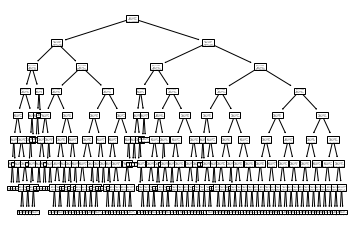

In [85]:
clf3 = tree.DecisionTreeClassifier(criterion='gini', max_depth=8)
clf3 = clf3.fit(xtrain, ytrain)

tree.plot_tree(clf3)

In [86]:
ypred3 = clf3.predict(xtest)

In [87]:
print("Accuracy :", metrics.accuracy_score(ytest, ypred3) * 100, '%')

Accuracy : 83.46774193548387 %


**entropy**

[Text(95.66871662969174, 212.91, 'X[0] <= 0.422\nentropy = 0.938\nsamples = 7438\nvalue = [2636, 4802]'),
 Text(32.62157035495924, 203.85, 'X[4] <= 0.343\nentropy = 0.513\nsamples = 2370\nvalue = [271, 2099]'),
 Text(15.906980298913044, 194.79, 'X[0] <= 0.404\nentropy = 0.301\nsamples = 1122\nvalue = [60, 1062]'),
 Text(10.661514945652174, 185.73, 'X[3] <= 0.617\nentropy = 0.259\nsamples = 1028\nvalue = [45, 983]'),
 Text(6.084171195652174, 176.67, 'X[1] <= 0.713\nentropy = 0.322\nsamples = 596\nvalue = [35, 561]'),
 Text(3.070516304347826, 167.60999999999999, 'X[3] <= 0.196\nentropy = 0.266\nsamples = 575\nvalue = [26, 549]'),
 Text(1.3646739130434784, 158.55, 'X[3] <= 0.181\nentropy = 0.881\nsamples = 10\nvalue = [3, 7]'),
 Text(0.9097826086956522, 149.49, 'X[1] <= 0.22\nentropy = 0.544\nsamples = 8\nvalue = [1, 7]'),
 Text(0.4548913043478261, 140.43, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(1.3646739130434784, 140.43, 'entropy = 0.0\nsamples = 7\nvalue = [0, 7]'),
 Text(

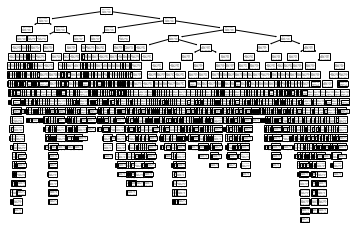

In [88]:
clf4 = tree.DecisionTreeClassifier(criterion='entropy')
clf4 = clf4.fit(xtrain, ytrain)

tree.plot_tree(clf4)

In [89]:
ypred4 = clf4.predict(xtest)

In [90]:
print("Accuracy :", metrics.accuracy_score(ytest, ypred4) * 100, '%')

Accuracy : 81.81451612903226 %


**max_depth + entropy**

[Text(137.04071120689656, 205.35999999999999, 'X[0] <= 0.422\nentropy = 0.938\nsamples = 7438\nvalue = [2636, 4802]'),
 Text(59.20331896551724, 181.2, 'X[4] <= 0.343\nentropy = 0.513\nsamples = 2370\nvalue = [271, 2099]'),
 Text(33.4078448275862, 157.04, 'X[0] <= 0.404\nentropy = 0.301\nsamples = 1122\nvalue = [60, 1062]'),
 Text(21.790862068965517, 132.88, 'X[3] <= 0.617\nentropy = 0.259\nsamples = 1028\nvalue = [45, 983]'),
 Text(11.833448275862068, 108.72, 'X[1] <= 0.713\nentropy = 0.322\nsamples = 596\nvalue = [35, 561]'),
 Text(6.349655172413793, 84.56, 'X[3] <= 0.196\nentropy = 0.266\nsamples = 575\nvalue = [26, 549]'),
 Text(3.463448275862069, 60.400000000000006, 'X[3] <= 0.181\nentropy = 0.881\nsamples = 10\nvalue = [3, 7]'),
 Text(2.308965517241379, 36.24000000000001, 'X[2] <= 0.25\nentropy = 0.544\nsamples = 8\nvalue = [1, 7]'),
 Text(1.1544827586206896, 12.079999999999984, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(3.463448275862069, 12.079999999999984, 'entropy = 

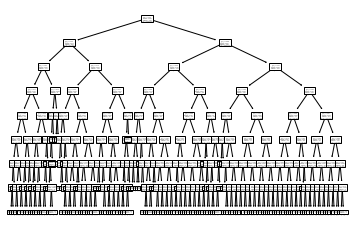

In [109]:
clf5 = tree.DecisionTreeClassifier(criterion='entropy', max_depth=8)
clf5 = clf5.fit(xtrain, ytrain)

tree.plot_tree(clf5)

In [110]:
ypred5 = clf5.predict(xtest)

In [111]:
print("Accuracy :", metrics.accuracy_score(ytest, ypred5) * 100, '%')

Accuracy : 84.39516129032259 %


**max_leaf_nodes**

[Text(79.76728065117105, 212.004, 'X[1] <= 0.287\ngini = 0.458\nsamples = 7438\nvalue = [2636, 4802]'),
 Text(19.588413768630236, 201.132, 'X[0] <= 0.439\ngini = 0.409\nsamples = 1370\nvalue = [978, 392]'),
 Text(3.8018452803406673, 190.26, 'X[3] <= 0.391\ngini = 0.168\nsamples = 194\nvalue = [18, 176]'),
 Text(1.9009226401703336, 179.388, 'X[0] <= 0.417\ngini = 0.122\nsamples = 184\nvalue = [12, 172]'),
 Text(0.9504613200851668, 168.516, 'gini = 0.071\nsamples = 162\nvalue = [6, 156]'),
 Text(2.8513839602555002, 168.516, 'X[4] <= 0.475\ngini = 0.397\nsamples = 22\nvalue = [6, 16]'),
 Text(1.9009226401703336, 157.644, 'X[4] <= 0.344\ngini = 0.48\nsamples = 15\nvalue = [6, 9]'),
 Text(0.9504613200851668, 146.772, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(2.8513839602555002, 146.772, 'X[2] <= 0.238\ngini = 0.496\nsamples = 11\nvalue = [6, 5]'),
 Text(1.9009226401703336, 135.9, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(3.8018452803406673, 135.9, 'X[2] <= 0.631\ngini = 0.44

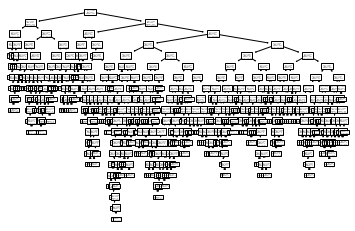

In [154]:
clf6 = tree.DecisionTreeClassifier(max_leaf_nodes=340)
clf6 = clf6.fit(xtrain, ytrain)

tree.plot_tree(clf6)

In [155]:
ypred6 = clf6.predict(xtest)

In [156]:
print("Accuracy :", metrics.accuracy_score(ytest, ypred6) * 100, '%')

Accuracy : 83.26612903225806 %
